In [1]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

In [2]:
X_train = np.load('regression/regression_x_train.npy').reshape((-1, 35))
y_train = np.load('regression/regression_y_train.npy').reshape(-1)
X_train.shape, y_train.shape

((172744, 35), (172744,))

In [3]:
X_test_vanilla = np.load('regression/regression_x_test.npy')
shape = X_test_vanilla.shape
X_test = pd.DataFrame(data=X_test_vanilla.reshape((-1, 35)), columns=["x_%i"%i for i in range(35)])

In [4]:
data = pd.DataFrame(data=np.concatenate([X_train, y_train.reshape((-1, 1))], axis=1),\
                    columns=["x_%i"%i for i in range(35)] + ['y'])

Рассмотрим связь признаков с целевой переменной. Заметим, что некоторые признаки значительно зашумлены. Присутствуют бинарные признаки и признаки, являющиеся константой. 

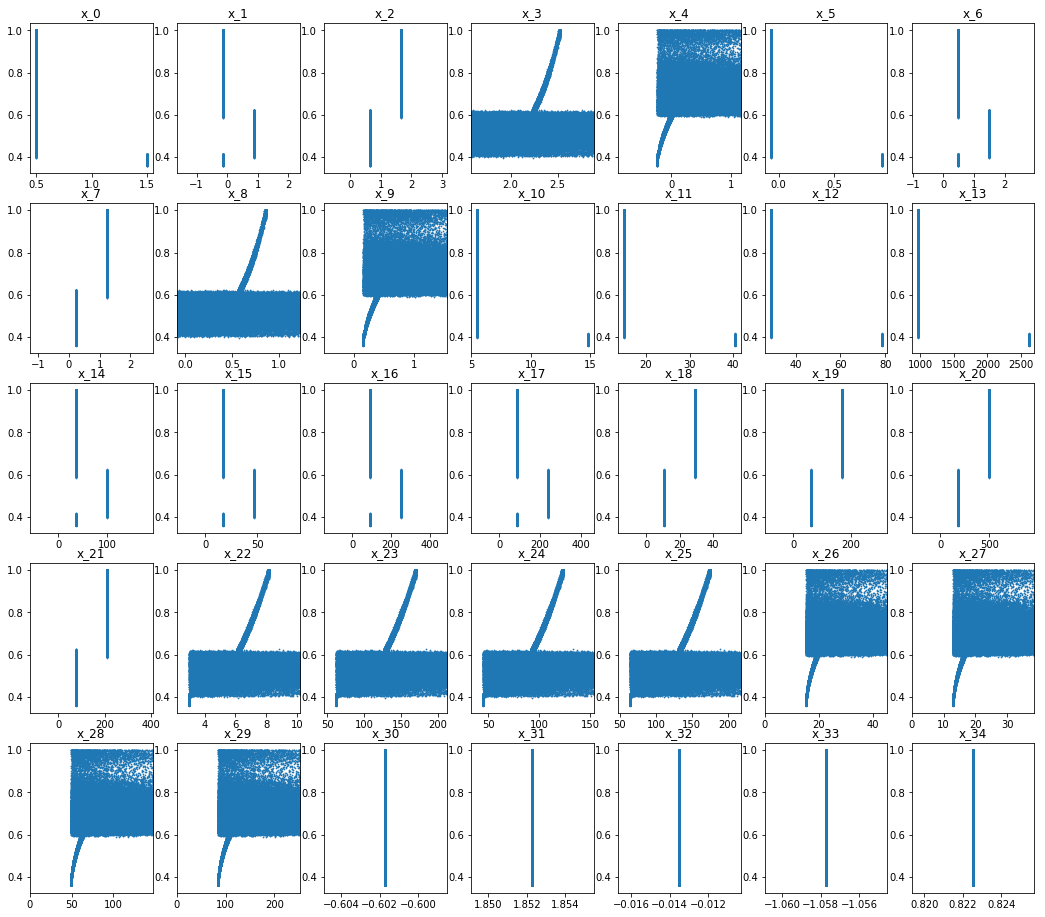

In [5]:
fig, axs = plt.subplots(5, 7, figsize=(18, 16))
axs = axs.flatten()
for i, ax in enumerate(axs):
    data_xi = data['x_%i'%i]
    low_bound = np.quantile(data_xi, 0.25) - 1.5 * st.iqr(data_xi)
    up_bound = np.quantile(data_xi, 0.75) + 1.5 * st.iqr(data_xi)
    ax.scatter(data_xi, data['y'], s=0.5)
    ax.set_title('x_%i'%i)
    if low_bound != up_bound:
        ax.set_xlim((low_bound, up_bound))

Рассмотрим число уникальных значений каждого из признаков, чтобы дальше разобрать каждый из них. 

In [6]:
nunique_stats = data.nunique()
nunique_stats

x_0          2
x_1          2
x_2          2
x_3      98899
x_4     100611
x_5          2
x_6          2
x_7          2
x_8      98899
x_9     100611
x_10         2
x_11         2
x_12         2
x_13         2
x_14         2
x_15         2
x_16         2
x_17         2
x_18         2
x_19         2
x_20         2
x_21         2
x_22     98899
x_23     98899
x_24     98899
x_25     98899
x_26    100611
x_27    100611
x_28    100611
x_29    100611
x_30         1
x_31         1
x_32         1
x_33         1
x_34         1
y       172430
dtype: int64

Константные признаки нас не интересуют, их мы сразу удаляем. 

In [7]:
const_mask = nunique_stats.values == 1
const_feat = nunique_stats.index.values[const_mask]
data = data.drop(const_feat, axis=1)

Бинарные признаки скалируем к {0, 1}.

In [8]:
binary_mask = nunique_stats.values == 2
binary_feat = nunique_stats.index.values[binary_mask]
for feat in binary_feat:
    # scale to 0, 1
    data[feat] = (data[feat] - data[feat].min()) / (data[feat].max()-data[feat].min())

Остальные признаки очищаем от выбросов, выбросы определяем по boxplot.

Наличие выброса в хотя бы одном признаке для объекта приводит к удалению данного объекта из рассматриваемой выборки. Число записей объектов существенно уменьшится, но их будет более чем достаточно для построения модели. 

In [9]:
cont_mask = nunique_stats.values > 2
cont_mask[-1] = False # ignore y
cont_feat = nunique_stats.index.values[cont_mask]
mask = np.ones(len(data)).astype(bool)

for feat in cont_feat:
    data_feat = data[feat].values
    low_bound = np.quantile(data_feat, 0.25) - 1.5 * st.iqr(data_feat)
    up_bound = np.quantile(data_feat, 0.75) + 1.5 * st.iqr(data_feat)
    feat_mask = (data_feat > low_bound) & (data_feat < up_bound)
    mask = mask & feat_mask
    X_test[feat] = X_test[feat].clip(low_bound, up_bound)

clean_data = data[mask]
print(data.shape, clean_data.shape)

(172744, 31) (119719, 31)


Рассмотрим данные после проделанного препроцессинга. Видим, что последний шаг (удаление выбросов) привел к вырождению некоторых бинарных признаков в константные. Быть может наличие выбросов в данных и значения этих признаков были связаны. В любом случае константные не нужны и их придется удалить. 

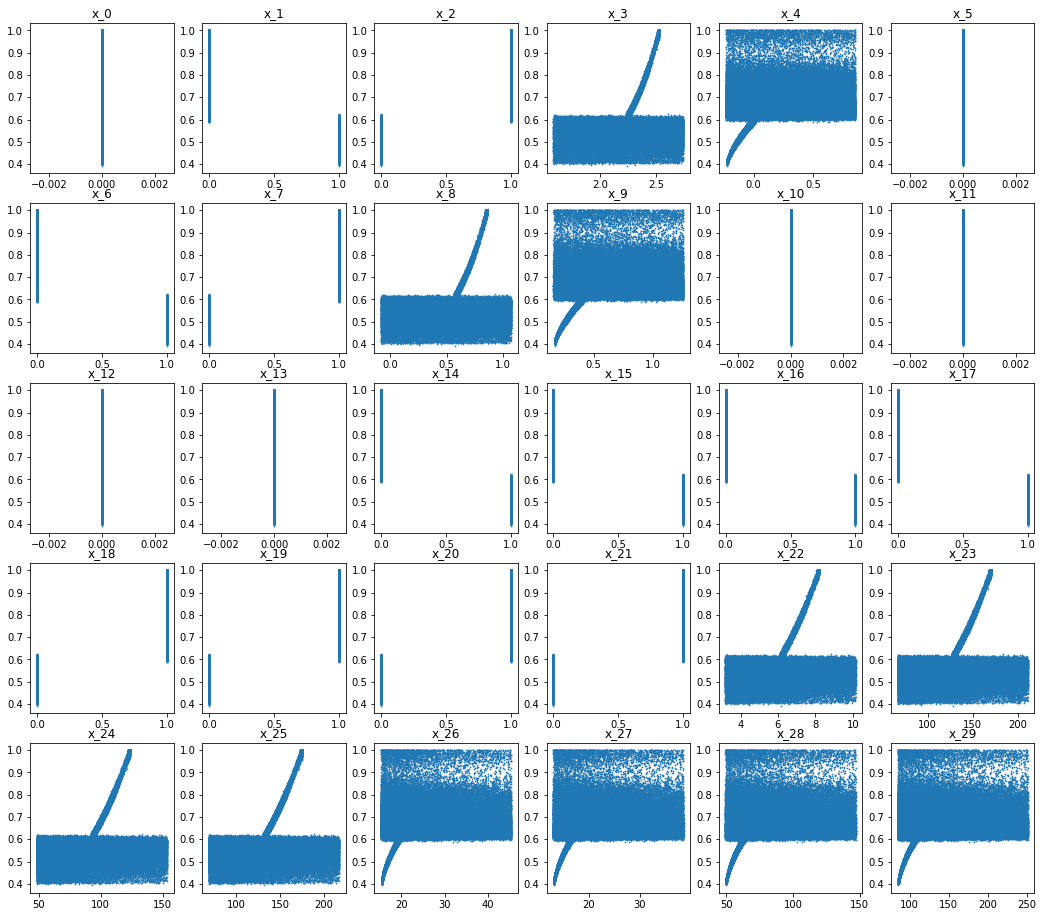

In [10]:
fig, axs = plt.subplots(5, 6, figsize=(18, 16))
axs = axs.flatten()
for i, feat in enumerate(clean_data.columns[:-1]):
    data_xi = clean_data[feat]
    axs[i].scatter(data_xi, clean_data['y'], s=0.5)
    axs[i].set_title(feat)

Удалим бинарные, которые стали константными. 

In [11]:
const_clean_mask = clean_data.nunique().values == 1
const_clean_feat = clean_data.nunique().index.values[const_clean_mask]
clean_data = clean_data.drop(const_clean_feat, axis=1)
print(clean_data.shape)

(119719, 25)


Строим график корреляций. 

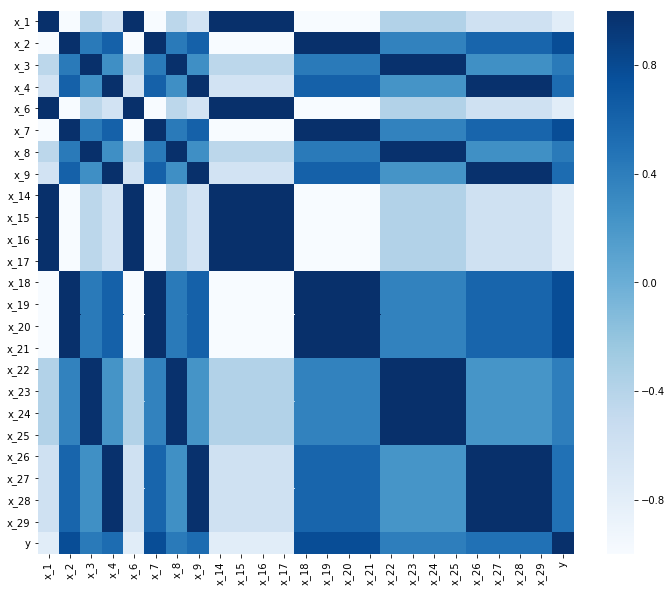

In [12]:
corr_matrix = clean_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='Blues');

Удаляем все идеально коррелирующий признаки. Оставляем только один, для построения линейной модели мультиколлинеарность не желательна. 

In [13]:
# drop duplicates
unique_feats = corr_matrix.round(10).drop_duplicates().index.values

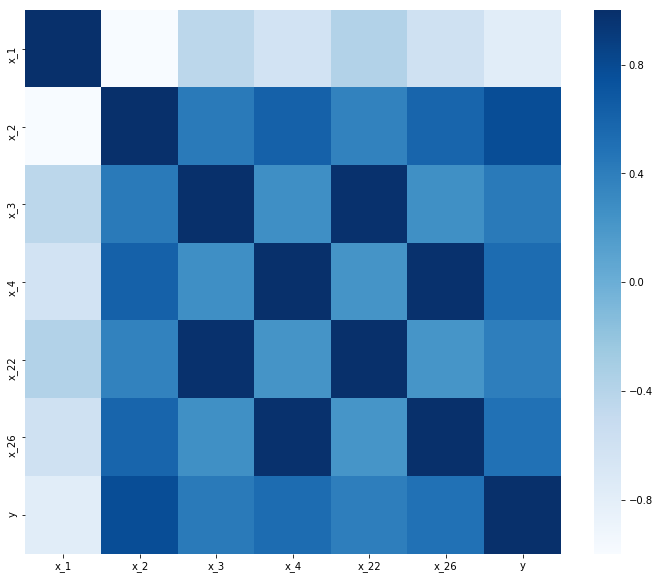

In [14]:
unique_corr_matrix = clean_data[unique_feats].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(unique_corr_matrix, cmap='Blues');

In [15]:
unique_clean_data = clean_data[unique_feats]

Мы отобрали признаки, на данном этапе их осталось 6, можем детально рассмотреть связь между ними. 

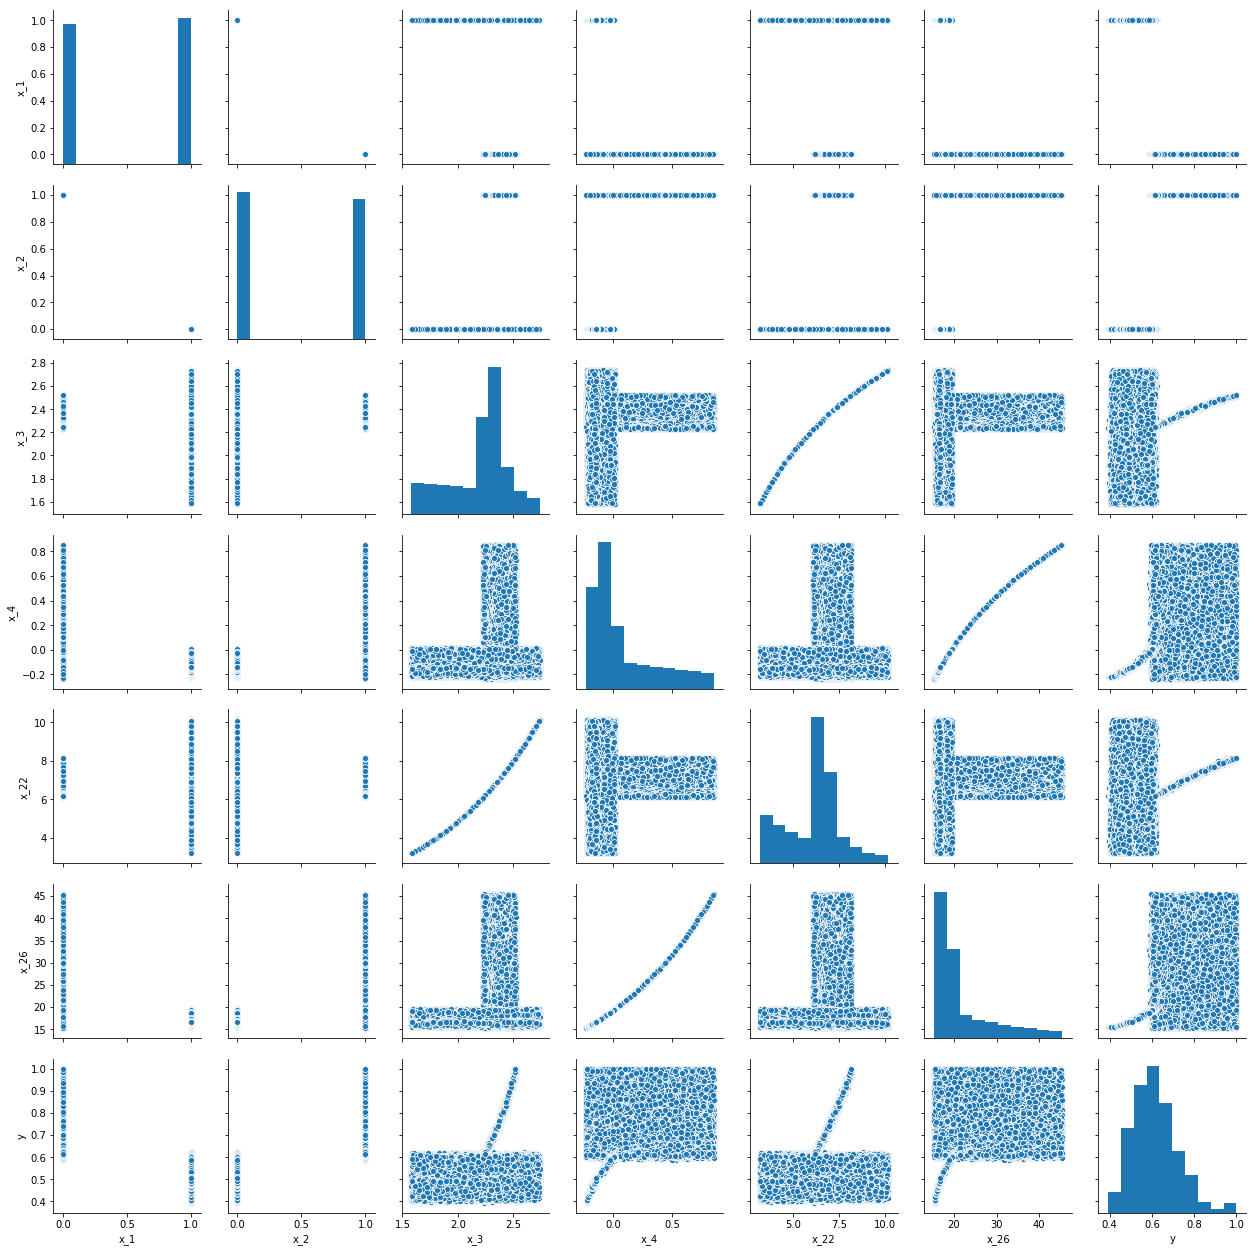

In [16]:
sns.pairplot(unique_clean_data);

Заметим, что x_1 и x_2 линейно связаны, проверим это. Действительно x_1 = 1 - x_2. Удаляем x_2.

In [17]:
# x_1 = 1 - x_2 -- linear
print((1 - clean_data['x_2'] - clean_data['x_1']).unique())
unique_clean_data = unique_clean_data.drop('x_2', axis=1)

[0.]


Попробуем построить первую модель. 

In [18]:
model1 = sm.OLS.from_formula('y ~ x_1 + x_3 + x_4 + x_22 + x_26', data=unique_clean_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                 4.580e+04
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        11:31:42   Log-Likelihood:             1.6132e+05
No. Observations:              119719   AIC:                        -3.226e+05
Df Residuals:                  119713   BIC:                        -3.226e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3909      0.007    191.371      0.000       1.377       1.405
x_1           -0.1512      0.001   -276.788      0.000      -0.152      -0.150
x_3           -0.3761      0.005    -73.826      0.000      -0.386      -0.366
x_4            0.4621      0.005     86.453      0.000       0.452       0.473
x_22           0.0738      0.001     84.346      0.000       0.072       0.076
x_26          -0.0164      0.000    -81.186      0.000      -0.017      -0.016
==============================================================================
Omnibus:                    23223.785   Durbin-Watson:                   0.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61037.499
Skew:                           1.057   Prob(JB):                         0.00
Kurtosis:                       5.787   Cond. No.                     1.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Качество недостаточно большое, рассмотрим межфакторные взаимодействия, которые мы можем потенциально добавить. 

In [19]:
formula = 'y ~ x_1 + x_3 + x_4 + x_22 + x_26 + '
features = unique_clean_data.columns[:-1]
for f1 in range(len(features)):
    for f2 in range(f1+1, len(features)): 
        f1_ = features[f1]
        f2_ = features[f2]
        model = sm.GLM.from_formula(formula+str(f1_)+':'+str(f2_),
                                    data=unique_clean_data, family=sm.families.NegativeBinomial()).fit()               
        for name, p in model.pvalues.items():
            if p<0.05 and ':' in name:
                print (f1_, f2_, model.bic)

x_1 x_3 -1399632.596689946
x_1 x_4 -1399499.367063225
x_1 x_22 -1399633.4021299118
x_1 x_26 -1399497.763634274
x_3 x_4 -1399392.6794391475
x_3 x_22 -1399373.4488168294
x_3 x_26 -1399412.8844764521
x_4 x_22 -1399414.9371688692
x_4 x_26 -1399399.5226318317
x_22 x_26 -1399432.3578708633


Можно пробовать разные, но здесь экспериментально лучше всего будут работать пары, включающие x_1. Причинность этого обсудим позже. 

In [20]:
unique_clean_data_ = unique_clean_data.copy()
unique_clean_data_['const'] = 1
model2 = sm.OLS.from_formula('y ~ const + x_1 + x_3 + x_4 + x_22 + x_26 + x_1:x_3 + + x_1:x_4 + x_1:x_22 + x_1:x_26',
                             data=unique_clean_data_).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.763e+06
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        11:31:44   Log-Likelihood:             4.3544e+05
No. Observations:              119719   AIC:                        -8.709e+05
Df Residuals:                  119709   BIC:                        -8.708e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3601      0.006    221.267      0.000       1.348       1.372
const          1.3601      0.006    221.267      0.000       1.348       1.372
x_1            0.4259      0.019     22.447      0.000       0.389       0.463
x_3           -2.3781      0.009   -261.892      0.000      -2.396      -2.360
x_4            0.0002      0.001      0.363      0.717      -0.001       0.001
x_22           0.5231      0.001    397.767      0.000       0.520       0.526
x_26       -7.242e-06   2.29e-05     -0.317      0.751    -5.2e-05    3.76e-05
x_1:x_3        2.3777      0.009    261.405      0.000       2.360       2.396
x_1:x_4        3.0742      0.013    232.706      0.000       3.048       3.100
x_1:x_22      -0.5230      0.001   -396.747      0.000      -0.526      -0.520
x_1:x_26      -0.1320      0.001   -176.031      0.000      -0.134      -0.131
==============================================================================
Omnibus:                      345.845   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.900
Skew:                          -0.024   Prob(JB):                     3.33e-98
Kurtosis:                       3.296   Cond. No.                     8.37e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Согласно тесту Вальда, нам действительно стоит добавить данные межфакторные взаимодействия. Данный результат согласуется с высоким качеством.

In [21]:
model2.wald_test('x_1:x_3 = x_1:x_4 = x_1:x_22 = x_1:x_26 = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4415754.95021735]]), p=0.0, df_denom=1.2e+05, df_num=2>

Отстатки распредлены нормально с нулевым средним. Тут все хорошо. 

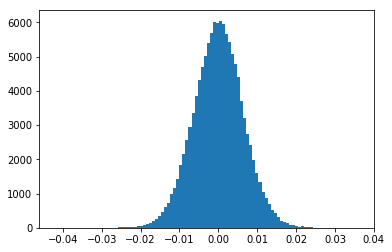

In [22]:
res = model2.resid
plt.hist(res, bins = 100)
plt.show()

Вернемся к той связи между x_1 и остальными отобранными признаками, которую мы отметили на этапе построения модели. 
Проверим предположение о том, что признак x_1 связан с шумом в остальных признаках. 

Рассмотрение данных признаков показало, что x_1, связан с генерацией данных остальных признаков: 
* для признаков x_3, x_22 при значении x_1=0 имеет место функциональная связь с y, а при x_1=1 наблюдается шум;
* для признаков x_4, x_26 картина обратная: при значении x_1=1 имеет место функциональная связь с y, а при x_1=0 наблюдается шум.

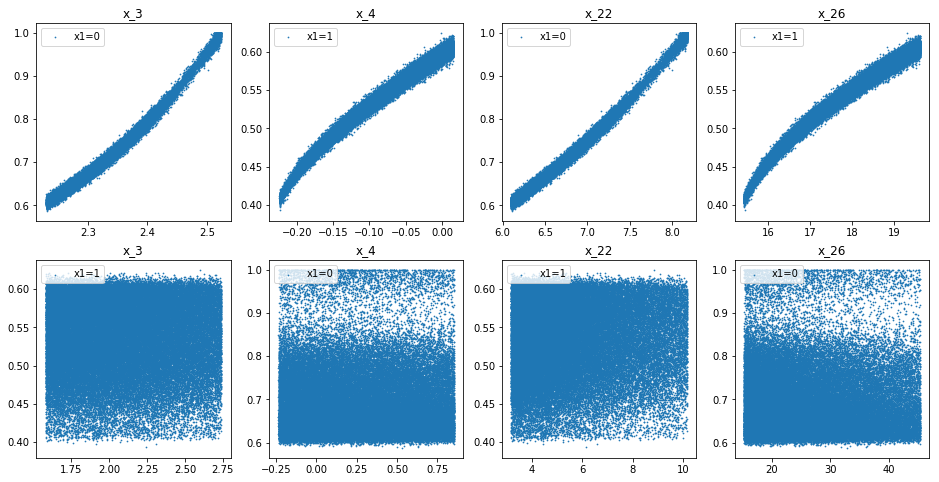

In [28]:
mask = unique_clean_data['x_1'] == 1

fig, (axs_func, axs_noisy) = plt.subplots(2, 4, figsize=(16, 8))
for i, feat in enumerate(unique_clean_data.columns[1:-1]):
    if feat in ['x_3', 'x_22']:
        axs_func[i].scatter(unique_clean_data[~mask][feat], unique_clean_data[~mask]['y'], s=0.5, label='x1=0')
        axs_noisy[i].scatter(unique_clean_data[mask][feat], unique_clean_data[mask]['y'], s=0.5, label='x1=1')
    else:
        axs_func[i].scatter(unique_clean_data[mask][feat], unique_clean_data[mask]['y'], s=0.5, label='x1=1')
        axs_noisy[i].scatter(unique_clean_data[~mask][feat], unique_clean_data[~mask]['y'], s=0.5, label='x1=0')
    
    axs_func[i].legend(loc=2)
    axs_noisy[i].legend(loc=2)
    axs_func[i].set_title(feat)
    axs_noisy[i].set_title(feat);

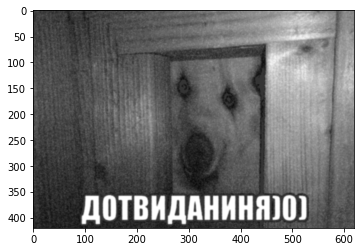

In [25]:
valid_feats = unique_clean_data.columns[:-1]

X_test = X_test[valid_feats]
X_test['const'] = 1
prediction = model2.predict(X_test).clip(0, 1)

plt.imshow(prediction.values.reshape(list(shape[:-1])), interpolation='bicubic', cmap='gray');

$\bf{Выводы:}$

1) В ходе отбора признаков были выкинуты константные признаки, так как они не несут никакой информации и поэтому не нужны для построения модели, также были удалены полностью коррелирующие признаки, поскольку в линейной модели мультиколлинеарность признаков приводит к большой дисперсии оценок, что нежелательно. Кроме этого, из данных были выброшены выбросы, которые определялись с помощью boxplot. Так как объем обучающей выборки большой, то это позволило просто удалить все шумовые точки. Но при этом некоторые биномиальные признаки выродились в константу, поэтомы они также были удалены. По итогам такого препроцессинга осталось 6 признаков x_1, x_2, x_3, x_4, x_22, x_26. После скалирования биномиальных признаков в [0, 1] было замечено, что x_2 полностью противоположен x_1, то есть x_2 = 1 - x_1, так как это линейная зависимость, то x_2 был удален.

2) По оставшимся 5 признакам была построена модель, которая изначально имела недостаточно высокое качество, но после добавления в нее межфакторных взаимодействий качество возрасло до $\bf{R^2 = 0.996}$. Остатки модели распределены нормально.

3) Интрепретация удаленным признакам была дана при объяснении причин их удаления. Интрерпретация оставшихся следующая. Было замечено, что значение признака x_1 определяет метод генерации всех остальных признаков. Для признаков x_3, x_22 при значении x_1 = 0 имеет место функциональная связь с y, а при x_1 = 1 наблюдается шум; для признаков x_4, x_26 картина обратная: при значении x_1 = 1 имеет место функциональная связь с y, а при x_1 = 0 наблюдается шум. Функциональная зависимость x_3, x_4, x_22, x_26 и y нелинейная, востанавливать ее мы не будем.

4) Качество полученного изображения довольно высокое.